In [57]:
using Agents
using Graphs
using DynamicalSystems
using InteractiveDynamics
using GLMakie
using CairoMakie
using GraphMakie
using Karnak
using NetworkLayout
using Plots
using StatsPlots

using Random
using Measures
using Compose, Cairo, Fontconfig
using Colors
using LaTeXStrings
using StatsBase

### Create Graph Space

In [58]:
SEED = 123

123

In [59]:
# set up the dims of grid
const NN = 13
const GRID_DIM = (NN,NN)

# agent num = 75% of the node
TOTAL_AGENTS = round( Int, 0.75*prod(GRID_DIM) );

# make a lattice grid graph space
# residential_graph = Graphs.grid( GRID_DIM, periodic=false )

Generate a graph residential_graph, and for each node in the graph, it is randomly deciding whether to add or remove edges based on the specified THRESHOLD_RAND_ALTER probability. This code simulates the dynamic alteration of edges in the graph, possibly representing changes in connectivity or relationships between nodes.

In [61]:
function AdjustGraph(graph, THRESHOLD_RAND_EDGE_ADD, THRESHOLD_RAND_EDGE_RM)

    for source_node in vertices(graph)

        # add edge
        if( rand() < THRESHOLD_RAND_EDGE_ADD )
            destination_node = rand( 1:nv(graph), 1)[1]

            if( destination_node != source_node )
                add_edge!(graph, source_node, destination_node)
            end
        end

        # remove edge
        if( rand() < THRESHOLD_RAND_EDGE_RM )
            neighbors = all_neighbors(graph, source_node)

            if( length(neighbors) > 0 )
                neighbor = rand( neighbors, 1)[1]
                rem_edge!(graph, source_node, neighbor)
            end
        end
    end
    return graph
end

AdjustGraph (generic function with 1 method)

In [62]:
function DiffEdgesGraphs(num_graphs, NN, THRESHOLD_RAND_EDGE_ADD, THRESHOLD_RAND_EDGE_RM)
    graphs = []
    GRID_DIM = (NN,NN)
    for i in 1:num_graphs
        residential_graph = Graphs.grid(GRID_DIM, periodic=false)
        
        adjusted_graph = AdjustGraph(residential_graph, THRESHOLD_RAND_EDGE_ADD, THRESHOLD_RAND_EDGE_RM)
        
        push!(graphs, adjusted_graph)
    end
    
    return graphs
end


DiffEdgesGraphs (generic function with 1 method)

In [64]:
graphs = DiffEdgesGraphs(4, 13, 0.20, 0.20)

4-element Vector{Any}:
 {169, 303} undirected simple Int64 graph
 {169, 320} undirected simple Int64 graph
 {169, 297} undirected simple Int64 graph
 {169, 314} undirected simple Int64 graph

In [65]:
num_edges = []
for graph in graphs
    push!(num_edges, graph.ne)
end

In [66]:
for graph in graphs
    @drawsvg begin
        background("white")
        drawgraph(graph, layout=squaregrid)
    end 400 400
end

### Set up model

In [67]:
@agent GraphSchellingAgent GraphAgent begin
    remain::Union{Number ,Bool}
    group::Int
end

In [68]:
model_iteration = 0;

In [69]:
rng1 = Random.Xoshiro(SEED)

Xoshiro(0xfefa8d41b8f5dca5, 0xf80cc98e147960c1, 0x20e2ccc17662fc1d, 0xea7a7dcb2e787c01)

In [70]:
function initialize(residential_graph)
    global model_iteration = 0
    
    space = GraphSpace( residential_graph )
    
    properties = Dict( :min_remain_percentage => 0.5 )
    
    
    model = UnremovableABM(GraphSchellingAgent, space; properties, 
                            rng=rng1, scheduler=Schedulers.Randomly() )
    
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    for agent_ind in 1:TOTAL_AGENTS
        remain_temp = false
        group_temp = agent_ind < TOTAL_AGENTS/2 ? 1 : 2
        new_position = random_empty(model)
        
        agent_temp = GraphSchellingAgent(agent_ind, new_position, remain_temp, group_temp)
        add_agent!(agent_temp, model)
    end
    return model
end

initialize (generic function with 1 method)

In [71]:
models = Vector{Any}()
for graph in graphs
    model = initialize(graph)
    push!(models, model)
end

### Agent Steps

In [72]:
function GetAgentNeighborStatus(agent,model)
    count_near = 0
    for pos in nearby_positions( agent.pos, model,1)
        count_near += 1
    end
    
    count_neighbors_same_group = 0    
    for neighbor in nearby_agents( agent, model )
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    return [count_near, count_neighbors_same_group]
end
    
    
function GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group)
        
    if( (count_neighbors_same_group / count_near) <= model.min_remain_percentage )
        return false
    else
        return true
    end
end

GetAgentRemainStatus (generic function with 1 method)

In [73]:
function agent_step!(agent, model)

    count_near, count_neighbors_same_group = GetAgentNeighborStatus(agent, model)
    
    agent.remain = GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group)

    if agent.remain == false
        #move to random position
        move_agent_single!(agent, model)
        
    end
end

agent_step! (generic function with 1 method)

In [74]:
function model_step!(model)
     global model_iteration += 1 
end

model_step! (generic function with 1 method)

### Caculate Entropy

H(x)=−p(x)ln(p(x))

https://chat.openai.com/share/2f8b5ccf-beee-4bbc-a036-61b9b58245e1

In [17]:
# Get the % of agent stay in their pos
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain 
    end
    return remain / nagents(model)
end

# Caculate graph entropy (Trace State) based on agent's group homogeneity
function GraphBaseEntropy(model)
    
    edge_total_num = 0
    agent_degree_distribution = Dict()
        
    for agent in allagents(model)
        edge_num = 0
        
        for near_agent in nearby_agents(agent,model, 1)
           if near_agent.group == agent.group
               edge_num += 1 
            end           
        end
        
        edge_total_num += edge_num
        
        if edge_num in keys(agent_degree_distribution)
            agent_degree_distribution[edge_num] += 1
        else
            agent_degree_distribution[edge_num] = 1
        end    
    end
    
    # Get agent_degree_distribution prob
    for k in keys(agent_degree_distribution)
        agent_degree_distribution[k] /= edge_total_num
    end
    
    #println(agent_degree_distribution)
    H = 0
    
     for k in keys(agent_degree_distribution)
        H += (-1) * agent_degree_distribution[k] * log(agent_degree_distribution[k])
        
    end
    
    return H
end

# Caculate graph entropy(Macro) based on node's connection
function GraphSpaceEntropy(model)
    G = model.space.graph

    node_total_num = nv(G)
    node_dregree_distrubution = Dict()
    
    for v in vertices(G)
        edge_num = length(collect(neighbors(G, v)))
        if edge_num in keys(node_dregree_distrubution)
            node_dregree_distrubution[edge_num] += 1
        else
            node_dregree_distrubution[edge_num] = 1
        end  
    end
    
    for k in keys(node_dregree_distrubution)
        node_dregree_distrubution[k] /= node_total_num
    end
    
    #println(node_dregree_distrubution)
    H = 0
    
    for k in keys(node_dregree_distrubution)
        H += (-1) * node_dregree_distrubution[k] * log(node_dregree_distrubution[k])       
    end

    return H

end


GraphSpaceEntropy (generic function with 1 method)

### Get Entropy in Model

In [75]:
graphs = []
push!(graphs, DiffEdgesGraphs(1, 13, 0.0, 0.0)) 
push!(graphs, DiffEdgesGraphs(1, 13, 0.20, 0.20))
push!(graphs, DiffEdgesGraphs(1, 13, 0.70, 0.70))    
push!(graphs, DiffEdgesGraphs(1, 13, 0.0, 0.90))
push!(graphs, DiffEdgesGraphs(1, 13, 0.0, 0.40))
push!(graphs, DiffEdgesGraphs(1, 13, 0.40, 0.0))
push!(graphs, DiffEdgesGraphs(1, 13, 0.70, 0.0))

7-element Vector{Any}:
 Any[SimpleGraph{Int64}(312, [[2, 14], [1, 3, 15], [2, 4, 16], [3, 5, 17], [4, 6, 18], [5, 7, 19], [6, 8, 20], [7, 9, 21], [8, 10, 22], [9, 11, 23]  …  [147, 159, 161], [148, 160, 162], [149, 161, 163], [150, 162, 164], [151, 163, 165], [152, 164, 166], [153, 165, 167], [154, 166, 168], [155, 167, 169], [156, 168]])]
 Any[SimpleGraph{Int64}(315, [[2, 14], [1, 3, 15], [2, 4, 16, 25], [3, 5, 17], [4, 6, 18], [5, 7, 19], [6, 8, 20], [7, 9, 21], [8, 10, 22], [9, 11]  …  [32, 161], [148, 160, 162], [161, 163], [65, 150, 162, 164], [151, 163, 168], [152, 166], [153, 165, 167], [154, 166, 168], [155, 164, 167, 169], [156, 168]])]
 Any[SimpleGraph{Int64}(315, [[2, 14], [1, 3, 15], [2, 4, 16, 22], [3, 5, 84, 104], [4, 18, 97], [7, 19], [6, 8, 150], [7, 15, 21, 115], [41, 140], [23, 116]  …  [134, 159], [95, 148, 162], [81, 149, 161, 163], [150, 162], [34, 95, 165], [132, 144, 164, 166], [31, 32, 153, 165], [154, 168], [76, 155, 167], [45, 84, 136, 146]])]
 Any[SimpleGraph

In [76]:

models = Vector{Any}()
for graph in graphs
    model = initialize(graph[1])
    push!(models, model)
end


mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]
step_num = 70

df = []
remain = []
graph_base_H =[]
graph_space_H = []

for (index, model) in pairs(models)
    
    _, model_df = run!(model, agent_step!, step_num; mdata)
    
    push!(df, model_df)
    push!(remain, model_df[:,:ModelRemainTrajectory])
    push!(graph_base_H, model_df[:,:GraphBaseEntropy])
    push!(graph_space_H, model_df[:,:GraphSpaceEntropy])
end

LOOPS = 1:50

for i in LOOPS
    models = Vector{Any}()
    for graph in graphs
        model = initialize(graph[1])
        push!(models, model)
    end
    for (index, model) in pairs(models)

        _, model_df = run!(model, agent_step!, step_num; mdata)
        graph_base_H[index] += model_df[:,:GraphBaseEntropy]
        remain[index] += model_df[:,:ModelRemainTrajectory]
    end
end

graph_base_H /= 1+length(LOOPS);
remain /= 1+length(LOOPS);


In [77]:
HGs = [g[1] for g in graph_space_H]
HGs = [round(h; digits=3) for h in HGs]
HGstr = [L"H_g="*"$(h)" for h in HGs]
HGstr = permutedims(HGstr)


1×7 Matrix{String}:
 "\$H_g=\$0.678"  "\$H_g=\$1.358"  …  "\$H_g=\$1.262"  "\$H_g=\$1.476"

In [78]:
#Plots.plot(graph_space_H, xlabel = "Steps",ylabel = "Entropy",legend=false, title="Model Entropy", size=(900, 500))

In [79]:
println(remain[1][end])

0.708507024857187


In [80]:
ends = [remain[i][end] for i in 1:length(remain)]

7-element Vector{Float64}:
 0.708507024857187
 0.7772116720704025
 0.7636251350934075
 0.9098348000617565
 0.874633317894086
 0.7616180330399872
 0.6784004940558901

In [81]:
sscore = corspearman(HGs, ends)
sscore = round(sscore; digits=3)

-0.214

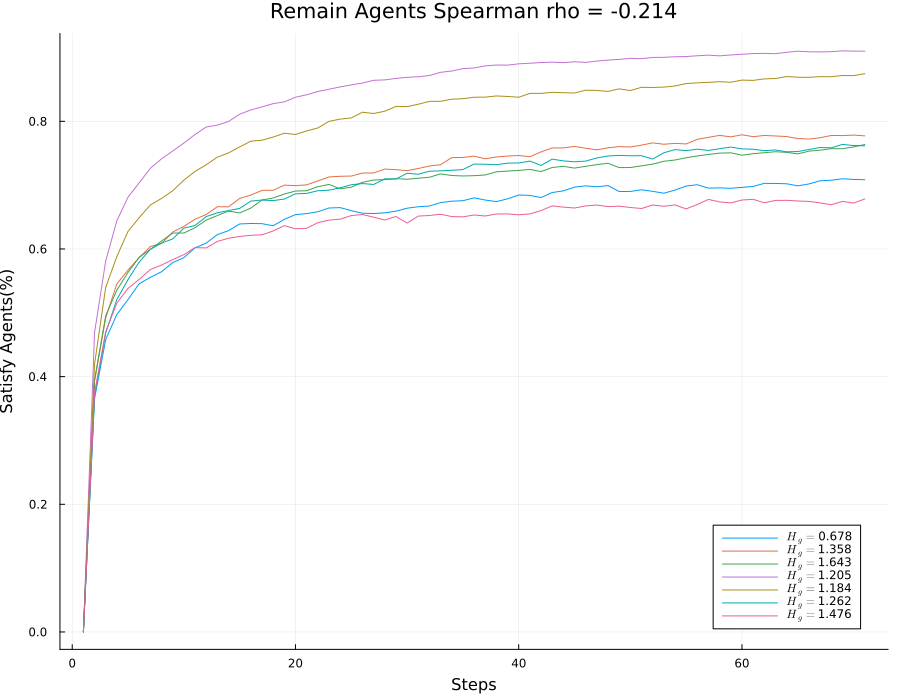

In [82]:
Plots.plot(remain, xlabel = "Steps",ylabel = "Satisfy Agents(%)",legend=true,labels = HGstr, title="Remain Agents Spearman rho = $(sscore)", size=(900, 700))

In [83]:
ends = [graph_base_H[i][end] for i in 1:length(graph_base_H)]

7-element Vector{Float64}:
 0.9936165175479836
 0.97465072181747
 0.9985213568915414
 1.1310033584320927
 0.977519090133564
 0.9146899749454965
 0.9140571802268778

In [84]:
s_score = corspearman(HGs, ends)
s_score = round(s_score; digits=3)

-0.25

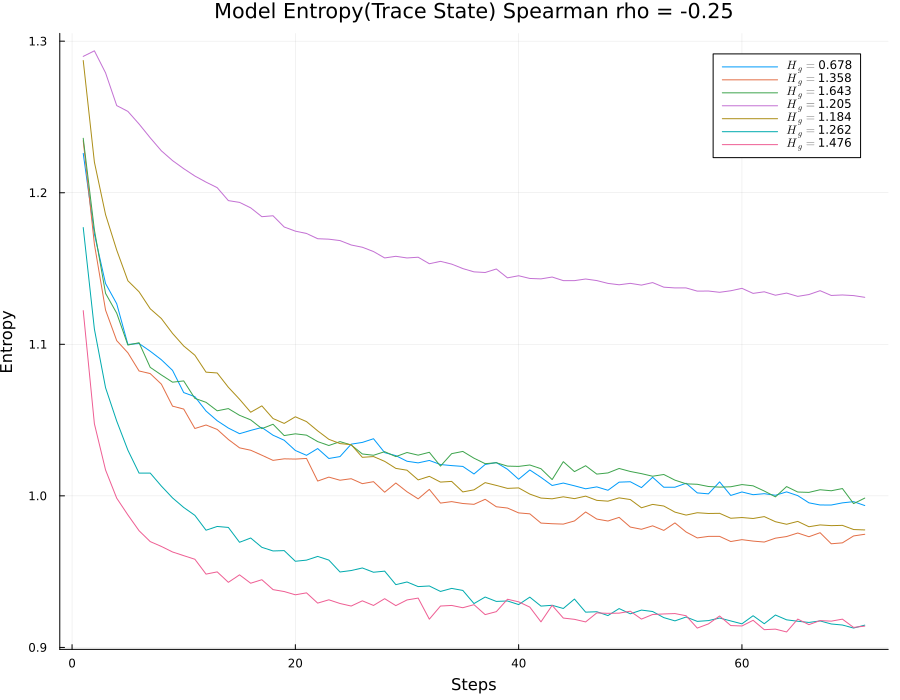

In [85]:
Plots.plot(graph_base_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr,title="Model Entropy(Trace State) Spearman rho = $(s_score)", size=(900, 700))

In [89]:
function NewPositionStatus(group, position, model)
    count_near = 0
    for pos in nearby_positions(position, model,1)
        count_near += 1
    end
    
    count_neighbors_same_group = 0    
    for id in nearby_ids( position, model , 1)
        agent = model[id]
        if agent.group == group
            count_neighbors_same_group += 1
        end
    end
    
    return [count_near, count_neighbors_same_group]
    
end



function GetAgentNeighborStatus2(agent,model)
    count_near = 0
    for pos in nearby_positions( agent.pos, model,1)
        count_near += 1
    end
    
    count_neighbors_same_group = 0    
    for neighbor in nearby_agents( agent, model )
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    
    return [count_near, count_neighbors_same_group]
end
    
    
function NextPosition(agent, model, count_near, count_neighbors_same_group)
    
    rand_pos = random_empty(model)
    count_near2, count_neighbors_same_group2 = NewPositionStatus(agent.group, rand_pos, model)
    identify_stat = (count_neighbors_same_group2 / count_near2) >= model.min_remain_percentage 

    if(identify_stat != true)
        return -1
    end
    # neigbor_prob = NeighborhoodProb(agent, model)
    neigbor_prob = NeighborhoodProb(rand_pos, model)
    # if(Int(identify_stat) * neigbor_prob < rand()) 
    if( Int(identify_stat) * neigbor_prob > rand() ) 
        return rand_pos
    else
        return -1

    end
end



function NeighborhoodProb(pos_new, model)
    neighbor_num_vec = []
    
    for agent_tmp in allagents(model)
        nearby_num = length(collect(nearby_positions(agent_tmp.pos, model)))
        push!(neighbor_num_vec, nearby_num)
    end
    
    nearby_num = length(collect(nearby_positions(pos_new, model)))
    push!(neighbor_num_vec, nearby_num)
    
    unique_neighbor_num = unique(neighbor_num_vec)
    prob_remain = Dict()
    
    for k in unique_neighbor_num
        prob_remain[k] = 1 - (length(findall(k .< neighbor_num_vec))/length(neighbor_num_vec))
    end
         
    return prob_remain[length(collect(nearby_positions(pos_new, model)))]
end

NeighborhoodProb (generic function with 1 method)

In [91]:
function agent_step2!(agent, model)

    count_near, count_neighbors_same_group = GetAgentNeighborStatus2(agent, model)
    
    remain_current = (count_neighbors_same_group / count_near) >= model.min_remain_percentage
    if remain_current == true
        agent.remain = 1
        return 
    end
       
    
    newPosition = NextPosition(agent, model, count_near, count_neighbors_same_group)
    if newPosition == -1
        agent.remain = 0
        return
    else
        agent.remain = 1
        move_agent!(agent , newPosition, model)
    end

end

agent_step2! (generic function with 1 method)

In [116]:

models = Vector{Any}()
for graph in graphs
    model = initialize(graph[1])
    push!(models, model)

end


mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]
step_num = 30

df = []
remain = []
graph_base_H =[]
graph_space_H = []

for (index, model) in pairs(models)
    
    _, model_df = run!(model, agent_step2!, step_num; mdata)
    
    push!(df, model_df)
    push!(remain, model_df[:,:ModelRemainTrajectory])
    push!(graph_base_H, model_df[:,:GraphBaseEntropy])
    push!(graph_space_H, model_df[:,:GraphSpaceEntropy])
end

LOOPS = 1:100

for i in LOOPS
    models = Vector{Any}()
    for graph in graphs
        model = initialize(graph[1])
        push!(models, model)
        
    end

    for (index, model) in pairs(models)

        _, model_df = run!(model, agent_step2!, step_num; mdata)
        graph_base_H[index] += model_df[:,:GraphBaseEntropy]
        remain[index] += model_df[:,:ModelRemainTrajectory]
    end
end

graph_base_H /= 1+length(LOOPS);
remain /= 1+length(LOOPS);


In [117]:
HGs = [g[1] for g in graph_space_H]
HGs = [round(h; digits=3) for h in HGs]
HGstr = [L"H_g="*"$(h)" for h in HGs]
HGstr = permutedims(HGstr)


1×7 Matrix{String}:
 "\$H_g=\$0.678"  "\$H_g=\$1.358"  …  "\$H_g=\$1.262"  "\$H_g=\$1.476"

In [118]:
ends = [remain[i][end] for i in 1:length(remain)]
sscore = corspearman(HGs, ends)
sscore = round(sscore; digits=3)

-0.786

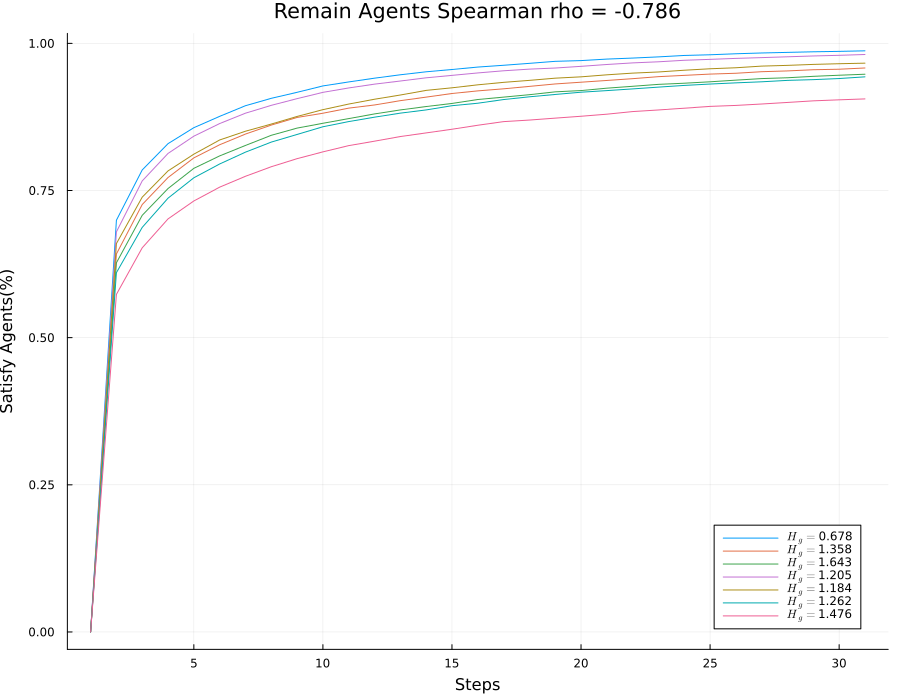

In [132]:
p1 = Plots.plot(remain, xlabel = "Steps",ylabel = "Satisfy Agents(%)",legend=true,labels = HGstr, title="Remain Agents Spearman rho = $(sscore)", size=(900, 700))

In [134]:
savefig(p1 , "./plots/remainUrbanRank.pdf")

"/home/resort/Documents/repos/thermalAgents/Networks/plots/remainUrbanRank.pdf"

In [120]:
ends = [graph_base_H[i][end] for i in 1:length(graph_base_H)]
s_score = corspearman(HGs, ends)
s_score = round(s_score; digits=3)

-0.143

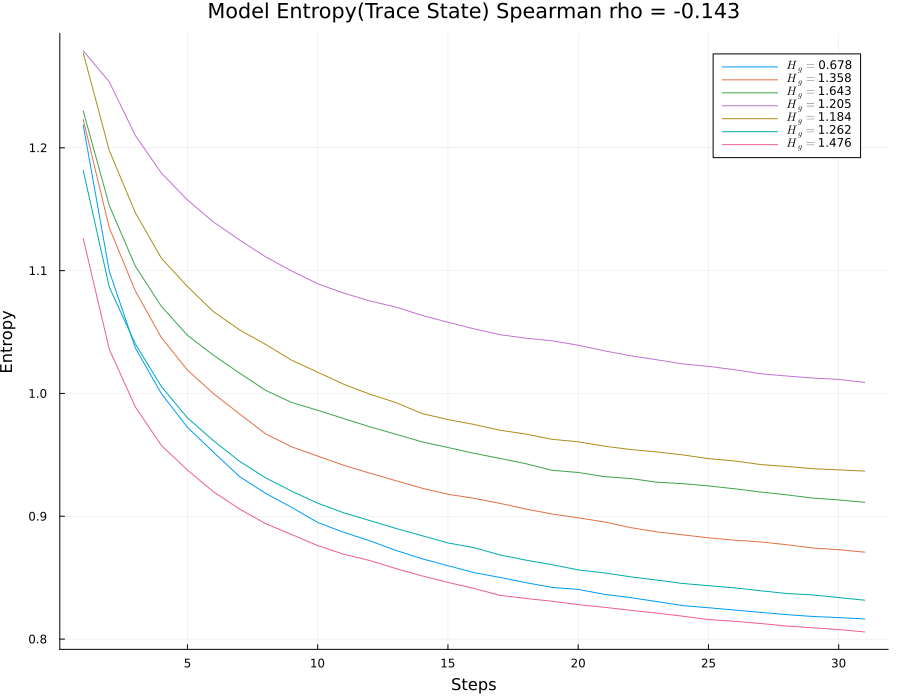

In [121]:
Plots.plot(graph_base_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr,title="Model Entropy(Trace State) Spearman rho = $(s_score)", size=(900, 700))

### Color node based on group

In [37]:
function VertexFillColors(graph, model)    
    vertex_colors = [ RGB(0, 0, 0) for i in 1:nv(graph) ]
    
    for agent in model.agents
        
        if( agent.group == 1 )
            vertex_colors[ agent.pos ] = RGB(1, 0.65, 0)
        else 
            vertex_colors[ agent.pos ] = RGB(0, 0, 1)
        end        
    end
    
    return vertex_colors
end

VertexFillColors (generic function with 1 method)

In [38]:
# Shape: Square means satisfy, circle means not

function VertexShape(graph, model)    
    vertex_shape = [:circle for i in 1:nv(graph)]
    
    for agent in model.agents
        
        if( agent.remain==true)
            vertex_shape[ agent.pos ] = :square
        else 
            vertex_shape[ agent.pos ] = :circle
        end        
    end
    
    return vertex_shape
end

VertexShape (generic function with 1 method)

### Visualize Graph after Steps

In [39]:
values_to_select = [0, 25, 50, 75, 100]
selected_rows = filter(row -> row.step in values_to_select, df[10])

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [10]

In [40]:
@drawsvg begin
    background("white")
    drawgraph(graphs[10], 
        layout=squaregrid,
        vertexshapes = VertexShape(graphs[10], models[10]),
        vertexshapesizes = [Graphs.outdegree(graphs[10], v) for v in Graphs.vertices(graphs[10])],
        vertexfillcolors = VertexFillColors(graphs[10], models[10]) )
    Karnak.text( "Graph Agent ", boxtopcenter() + (0, 10), halign=:center)
end 400 400

LoadError: LoadError: UndefVarError: `@drawsvg` not defined
in expression starting at In[40]:1